# BANCA ICCREA PROJECT #

## DATA CLEANING ##

First of all we import the packets we need for this first part of the project in which we put all the dataset we collected together

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

For the first dataset we drop the useless features than are unique values or extremely correlated to other features.
We then drom any NAs since there are not so many and then we also drop the duplicates.
We check for error and we find that in liquidity scores there is a score of -9997 which is absolutely an error since liquidity score can go from 0 to 100.
Finally we create the Coupon Type variable to prepare the dataset for the merge, in this case we have all FIXED bonds type as the dataset was sent to us with these characteristics.

In [66]:
df1 = pd.read_csv("C:/Users/leona/LUISS/Data science/banca iccrea.csv", delimiter = ";", header=1)

df1.drop(["ID", "Bid Price", "Ask Price"], axis = 1, inplace = True)

df1.dropna(axis = 0, inplace = True)

df1.drop_duplicates(inplace = True)

df1.drop(df1[df1["LQA Liquidity Score"]<0].index, inplace = True)

list_fixed = []
for el in df1["Outstanding Amount"]:
    list_fixed.append("FIXED")
    
df1["Coupon Type"] = list_fixed   

Same thing for the second dataset which had some more strange values like dashes.
We drop the column that we do not need as they are unique or correlated and we replace the dashes with null valies to drop them after this

In [67]:
df2 = pd.read_csv("C:/Users/leona/LUISS/Data science/LQA Liquidity Score 2nd dataset.csv", delimiter = ";", header=1)

df2.drop(["ID", "Security", "Bid-Ask Spread"], axis = 1, inplace = True)

df2["Outstanding Amount"] = df2["Outstanding Amount"].replace(" -   ", np.nan)

df2.dropna(axis = 0, inplace = True)

For the third dataframe we drop issuer name and ticker that do not have valuable informations, S&P rating and ESG disclosure score since from bloomberg these columns were composed of only null values, Cntry of Incorp since it has too many unique values and the others variables that were extremely correlated.
To prepare also this dataset to the merge we change the variables name matching the other two datasets.
Than we dropped all the null values but here there was no np.nan, instead there was #N/A Review so we created a new column with np.nan where it encounter thix string and then drop the NAs in the axis 0 and dropped the new column created.
Finally we drop duplicates and we change the type of the response variable from object to int.

In [68]:
df3 = pd.read_csv("C:/Users/leona/LUISS/Data science/bonds nostri.csv", delimiter = ";", header=0)

df3.drop(["Issuer Name", "Ticker", "S&P Rating", "ESG Disclosure Score", "Cntry of Incorp", "Ask Price", "Bid Price" ], axis = 1, inplace = True)


df3.columns = ["Coupon Type", "LQA Liquidity Score", "Outstanding Amount", "Time to Maturity (years)", "Duration", "Yield", "Mid Price", "LQA Price Volatility", "LQA Expected Daily Volume"]


listna = []

for el in df3["Coupon Type"]:
    if el == "#N/A Review":
        listna.append(np.nan)
    else:
        listna.append(el)
        
df3["listna"] = listna

df3.dropna(axis = 0, inplace = True)

df3.drop("listna", axis = 1, inplace = True)


df3 = df3.drop_duplicates()

df3["LQA Liquidity Score"] = df3["LQA Liquidity Score"].astype("int")

Now we finally are able to merge all the datasets and create the final dataset where we will work to train our models

In [69]:
df = pd.concat([df1, df2, df3], axis = 0)

df.reset_index(inplace = True, drop = True)

Here we noticed that the coupon Type column had identical categories but some of them had spaces on the sides so we use the strip function to delete every space at the start or at the end of the string.
Then after creating a new dataset we drop the coupon type column from the main dataframe to create dummy variables and to transform easily the numerical values from objects to numericals.

In [70]:
df_categorical = df["Coupon Type"].str.strip()

df.drop(["Coupon Type"], axis = 1, inplace = True)

To further prepare the dataset for scaling we change all the columns to numericals.

In [71]:
def str_to_float(num_str):
    num_str = num_str.replace(".", "").replace(",", ".")
    return float(num_str)
        
        
cols = df.columns


for col in cols:
    if df[col].dtype == "object":
        df[col] = df[col].apply(str_to_float)

Than we check if there are other variables that are extremely correlated with a correlation table

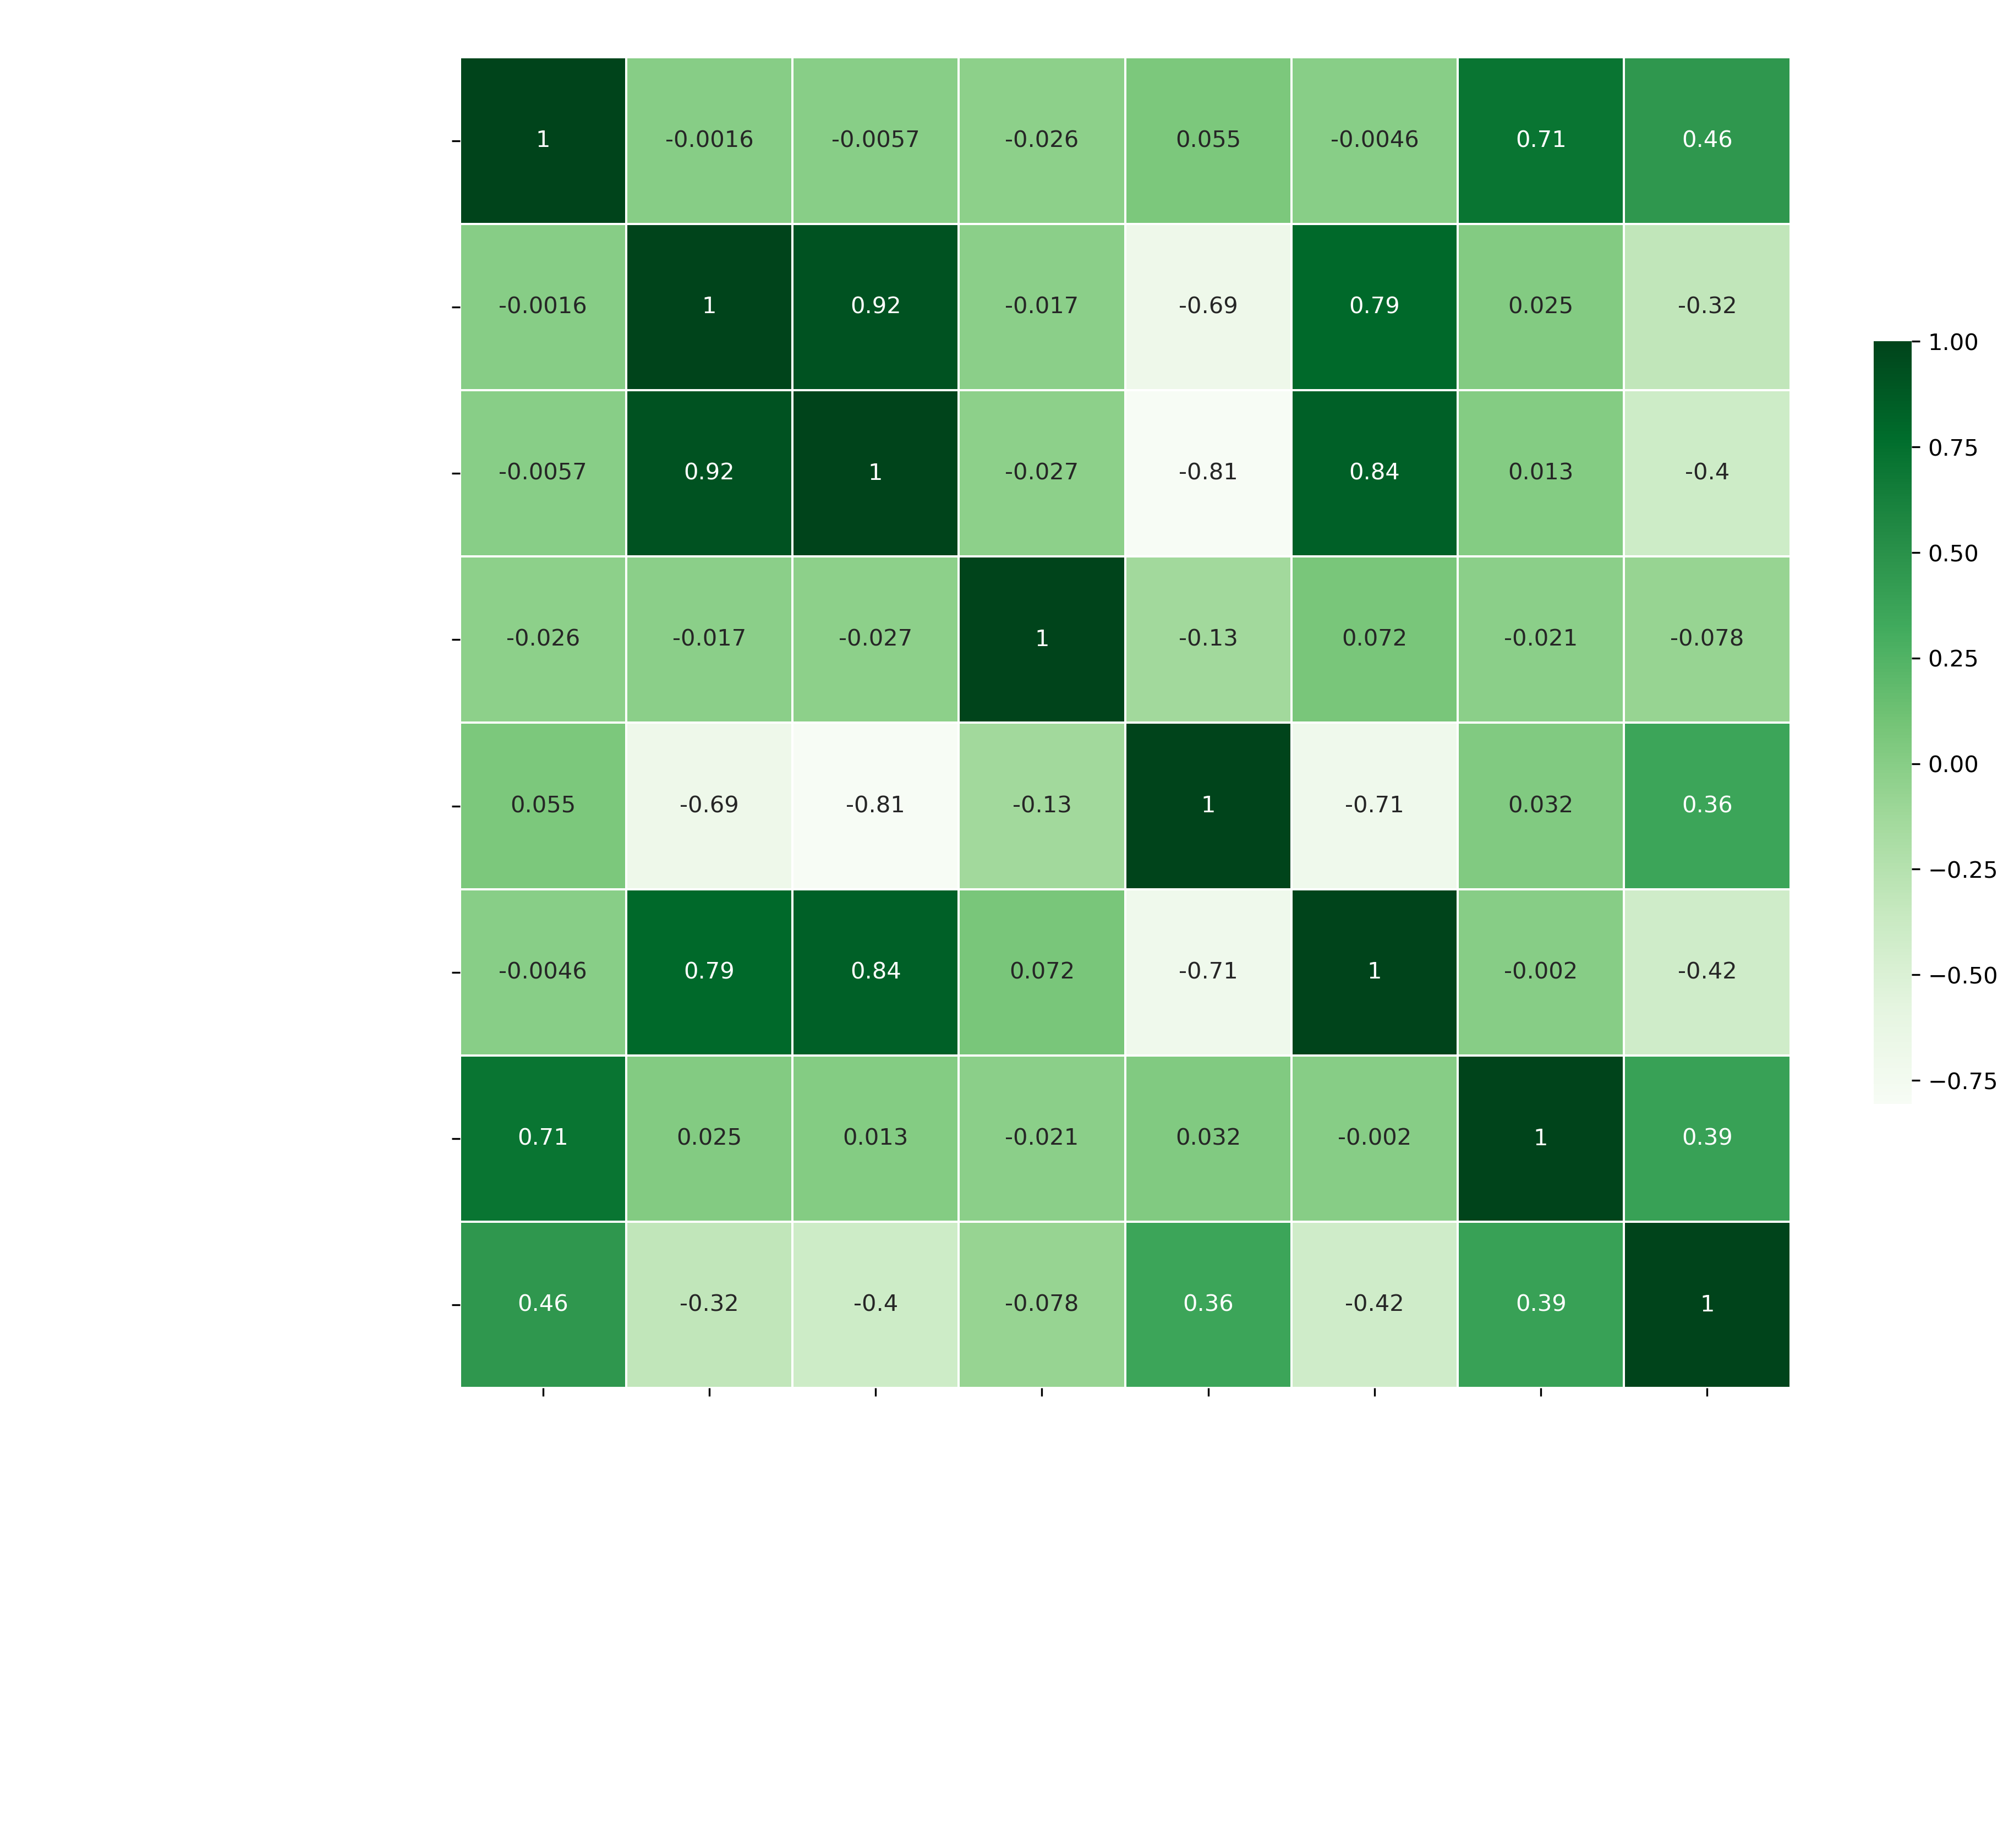

In [72]:
import seaborn as sns
corr = df.corr()
corr
fig, ax = plt.subplots(figsize=(13,12), dpi = 300)

# Generate a custom diverging colormap
cmap = sns.color_palette("Greens", as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot = True, cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot_kws = {"fontsize":10})

# Set title
ax.set_title('Liquidity score Correlation Heatmap', fontsize=16, color = "white")

ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold', fontsize=12, color='white')
ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold', fontsize=12, color='white')


plt.savefig("C:/Users/leona/LUISS/Data science/correlation_heatmap.png", transparent=True)

plt.show()

Duration is highly correlated with Time to maturity so we drop one of them. In this case we chose duration since it is also highly correlated with mid price and lqa price volatility.
After dropping we create the dummy variables for the categorical feature and we concat the df and the df categorical to have our final dataset to work on

In [73]:
df.drop("Duration", axis = 1, inplace = True)

df_categorical = pd.get_dummies(df_categorical)

df_full = pd.concat([df, df_categorical], axis=1)

## TRAIN TEST SPLIT ##

We divide in X and y (predictors and response variables) and we check if y is normal

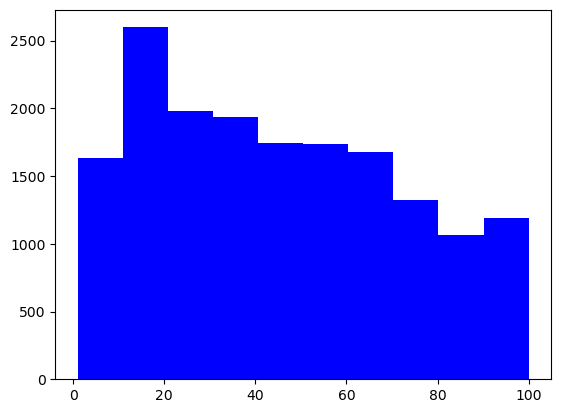

In [156]:
X = df_full.iloc[:, df_full.columns != 'LQA Liquidity Score']

col = X.columns

y = df_full.iloc[:,df_full.columns == "LQA Liquidity Score"]
        
plt.hist(y, color = "blue")
plt.savefig("C:/Users/leona/LUISS/Data science/Banca iccrea images/y_distr.png", dpi = 300, bbox_inches = "tight")
plt.show()

## Stratification ##

Here we create a temporary variable to stratify the dataset based on the liquidity score we had. In this way we avoid that, randomly chosen, the low/high LQA score are all in the test or all in the train/test and the model does not understand the min/max value of the response variable. Obviously we will drop this variable immediately after the train_test split because we don't want any data leakage

In [75]:
# Define the bins for the categories
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Define the labels for the categories
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']

# Create a new column with the categories based on the numerical column
X["bins"] = pd.cut(y.values.ravel(), bins=bins, labels=labels)

Now we do the train_test split and immediately drop the bins variable. We used a 80/20 % as ratio between train and test since we have a relatively large dataset.

In [76]:
from sklearn.model_selection import train_test_split

X_train, X_validation, y_training, y_validation = train_test_split(X, y, test_size = 0.2, stratify = X["bins"])


X_train = X_train.drop("bins", axis = 1)

X_validation = X_validation.drop("bins", axis = 1)

After this we divide the numerical columns from the categorical columns to prepare the dataset for scaling

In [77]:
columns = list(X_train.iloc[:,6:].columns)

X_train_cat = X_train[columns]

X_val_cat = X_validation[columns]


X_train.drop(columns, axis = 1, inplace = True)

X_validation.drop(columns, axis = 1, inplace = True)


col_train = X_train.columns

## Scaling

Finally we scale the train and test (only X not thwe response) and we fit the standard scaler only on X_train and transform the test with this same standard scaler since we don't want data leakage).
To merge than the scaled numerical dataset and the categorical dataset we use a "merge" temporary list to use the function pd.merge().

In [78]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X_train_scaled = pd.DataFrame(sc.fit_transform(X_train), columns = col_train)
X_val_scaled = pd.DataFrame(sc.transform(X_validation), columns = col_train)
y_train = y_training.values
y_val = y_validation.values


listmerge = []
x = 0
for i in X_train_scaled["Outstanding Amount"]:
    listmerge.append(x)
    x += 1
    

listmerge_val = []

xz = 0
for el in X_val_scaled["Outstanding Amount"]:
    listmerge_val.append(xz)
    xz += 1


X_train_scaled["merge"] = listmerge
X_train_cat["merge"] = listmerge

X_val_scaled["merge1"] = listmerge_val
X_val_cat["merge1"] = listmerge_val


X_train_scaled = pd.merge(X_train_scaled, X_train_cat, on = "merge")

X_val_scaled = pd.merge(X_val_scaled, X_val_cat, on = "merge1")

X_train_scaled.drop("merge", axis = 1, inplace = True)

X_val_scaled.drop("merge1", axis = 1, inplace = True)

Now that we have completed the preprocessing we can pass on the models.
We decided to do two interpretable models (linear regression and support vector regressor), three ensemble methods (Random Forest, gradient boosting regressor and xgboost regressor) and one neural network.
First of all we import all the packages that we need in all the models.

In [79]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import numpy as np

We create a dataframe to remember and compare the performances of the model from here on. In the dataframe there will be the name of the moedl and two performance metrics that are R2 and RMSE. R2 since we want to know the actual performance and RMSE to catch the loss of the model.

In [80]:
df_performance = pd.DataFrame(columns = ["Model", "R2", "RMSE"])

# Linear methods

## Linear regression

First of all, also if the response variable is not normal, we try a simple linear regression that will be our baseline for our future models.
We do not expect this to perform well in any sense.
To see the result we also plot the regression line to see how much it capture the validation y.

In [81]:
from sklearn.linear_model import LinearRegression

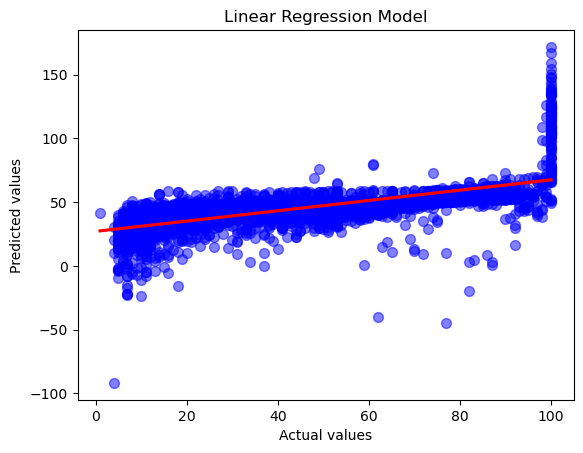

In [153]:
linear = LinearRegression()

fit_linear = linear.fit(X_train_scaled, y_train)

y_pred_linear = fit_linear.predict(X_val_scaled)

r2_linear = r2_score(y_val, y_pred_linear)

RMSE_linear = np.sqrt(mean_squared_error(y_val, y_pred_linear))

import seaborn as sns

sns.regplot(x=y_val.ravel(), y=y_pred_linear.ravel(), line_kws={'color': 'red'}, scatter_kws={'color': 'blue', 'alpha': 0.5, 's': 50})
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Linear Regression Model')
plt.savefig("C:/Users/leona/LUISS/Data science/Banca iccrea images/linear_regression.png", dpi = 300, bbox_inches = "tight")
plt.show()

In [83]:
df_performance.loc[0] = ["linear", r2_linear, RMSE_linear]
df_performance

,Model,R2,RMSE
0,linear,0.402002,21.219487


## SVR

After this we do an SVR that is a very useful model, since it is interpretable and will surely do better than the linear regression. SVR has a problem in this case since it doesn't scale well with huge dataset. Our dataset is nor huge nor little so the gridsearch is really slow 

In [84]:
from sklearn.svm import SVR

In [ ]:
model_SVR = SVR()

param_grid_SVR = {
    'kernel': ['poly', 'rbf'],
    'C': [0.1, 1, 10, 100],
    'gamma': [1e-3, 0.01, 0.1, 0.2, 0.5, 0.6]
}

# Perform Grid Search
grid_search_SVR = RandomizedSearchCV(estimator = model_SVR, param_distributions= param_grid_SVR, cv=5, n_jobs=-1)

fit_SVR = grid_search_SVR.fit(X_train_scaled, y_train.ravel())

fit_SVR.best_params_

y_pred_SVR = fit_SVR.predict(X_val_scaled)

r2_SVR = r2_score(y_val.ravel(), y_pred_SVR.ravel())

RMSE_SVR = np.sqrt(mean_squared_error(y_val, y_pred_SVR))

In [88]:
model_SVR = SVR(C = 100, gamma = 0.6, kernel = "rbf")

fit_SVR = model_SVR.fit(X_train_scaled, y_train.ravel())

y_pred_SVR = fit_SVR.predict(X_val_scaled)

r2_SVR = r2_score(y_val.ravel(), y_pred_SVR.ravel())

RMSE_SVR = np.sqrt(mean_squared_error(y_val, y_pred_SVR))

Also in this case it is possible to visualize the fitting line and we see that it is much better than the linear regression one

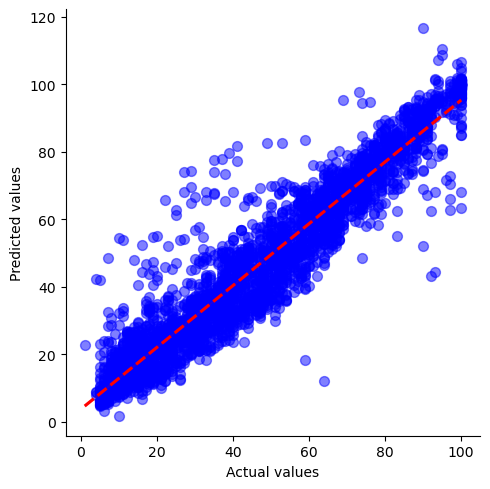

In [152]:
import seaborn as sns

# create a DataFrame with actual and predicted values
df_svr = pd.DataFrame({'Actual': y_val.ravel(), 'Predicted': y_pred_SVR.ravel()})

# plot the data with a line of best fit using lmplot()
sns.lmplot(x='Actual', y='Predicted', data=df_svr, line_kws={'color': 'red', 'linestyle': '--'},
           scatter_kws={'color': 'blue', 'alpha': 0.5, 's': 50})


# set the axis labels
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.savefig("C:/Users/leona/LUISS/Data science/Banca iccrea images/SVR.png", dpi = 300, bbox_inches = "tight")
plt.show()

In [93]:
df_performance.loc[1] = ["SVR", r2_SVR, RMSE_SVR]
df_performance

,Model,R2,RMSE
0,linear,0.402002,21.219487
1,SVR,0.908686,8.291892


# ENSAMBLE METHODS

## RANDOM FOREST REGRESSOR

After our first two interpretable model to improve our results we pass on the ensemble methods with the random forest. Obviously we gridsearch it to find the best hyperparameter. It is a slow process with many parameters so we used the gridsearchcv only one time to get the best parameters but we also wrote a randomizedsearchCV to get the hyperparameter faster in case of changing dataset.

In [94]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rfr = RandomForestRegressor()
param_grid = { 
    "n_estimators"      : [700, 1000, 1500],
    "criterion" : ["squared_error", "absolute_error", "friedman_mse"],
    "max_features"      : ["sqrt", "log2"],
    "min_samples_split" : [2,4,8,10],
    "bootstrap": [True, False],
    }

grid = GridSearchCV(estimator = rfr, param_grid = param_grid, cv = 5, n_jobs = -1, verbose=3, scoring = "r2")

rfr_grid = grid.fit(X_train_scaled, y_train.ravel())

y_pred = rfr_grid.predict(X_val_scaled)

r2 = r2_score(y_val, y_pred)

In [ ]:
# random forest with random_search cv-----------------------------------------------------------------------------------------------

rfr_rand = RandomForestRegressor()
param_grid_rand = { 
    "n_estimators"      : [700, 1000, 1500],
    "criterion" : ["squared_error", "absolute_error", "friedman_mse"],
    "max_features"      : ["sqrt", "log2"],
    "min_samples_split" : [2,4,8,10,12],
    "bootstrap": [True, False],
    }

grid_rand = RandomizedSearchCV(estimator = rfr_rand, param_distributions= param_grid_rand, cv = 5, n_jobs = -1, verbose=3, scoring = "r2")

rfr_grid_rand = grid_rand.fit(X_train_scaled, y_train.ravel())

y_pred_rand = rfr_grid_rand.predict(X_val_scaled)

r2_rand = r2_score(y_val, y_pred_rand)

In [95]:
rfr_rand = RandomForestRegressor(n_estimators= 1000, min_samples_split= 2,
max_features= 'log2',
criterion= 'squared_error',
bootstrap= False)

rfr_grid_rand = rfr_rand.fit(X_train_scaled, y_train.ravel())

y_pred_rand = rfr_grid_rand.predict(X_val_scaled) 

r2_rand = r2_score(y_val, y_pred_rand)
RMSE_rand = np.sqrt(mean_squared_error(y_val, y_pred_rand))

In [96]:
df_performance.loc[2] = ["Random Forest", r2_rand, RMSE_rand]
df_performance

,Model,R2,RMSE
0,linear,0.402002,21.219487
1,SVR,0.908686,8.291892
2,Random Forest,0.984623,3.402701


# Gradient boosting

Gradient boosting is another interesting option being a powerful ensemble method. We gridsearch it with a gridsearchCV with the parameter under and we noticed a great jump in performance as well as being more stable trying it more times with different seeds

In [97]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
gradient = GradientBoostingRegressor()

param_gradient ={'learning_rate': [0.01,0.1, 0.001],
            'subsample'    : [0.9, 0.5, 0.1],
            'n_estimators' : [100,500,1000],
            'max_depth'    : [4,6,8,10]
            }

grid_grad = GridSearchCV(estimator = gradient, param_grid = param_gradient, cv = 5, n_jobs = -1, verbose=3, scoring = "r2")

gradient_grid = grid_grad.fit(X_train_scaled, y_train.ravel())

best_gradient_estimators = gradient_grid.best_params_

y_pred_gradient = gradient_grid.predict(X_val_scaled)

r2_gradient = r2_score(y_val, y_pred_gradient)

In [102]:
gradient = GradientBoostingRegressor(learning_rate= 0.01, max_depth = 10, n_estimators = 1000, subsample = 0.5)

gradient_grid = gradient.fit(X_train_scaled, y_train.ravel())

y_pred_gradient = gradient_grid.predict(X_val_scaled)

r2_gradient = r2_score(y_val, y_pred_gradient)

rmse_gradient = np.sqrt(mean_squared_error(y_val, y_pred_gradient))

print(r2_gradient, rmse_gradient)

0.9864334621477091 3.1960931138431317


In [103]:
df_performance.loc[3] = ["Gradient boosting", r2_gradient, rmse_gradient]
df_performance

,Model,R2,RMSE
0,linear,0.402002,21.219487
1,SVR,0.908686,8.291892
2,Random Forest,0.984623,3.402701
3,Gradient boosting,0.986433,3.196093


We were afraid our model was overfitting since it did many times an r2 of 0.995 on the train. So we did this graph that plots residuals and predicted values. If we found patterns on this image it would've meant that overfitting was occurring but as we can see the points are all scattered randomly around the 0 so overfitting is not a problem here.

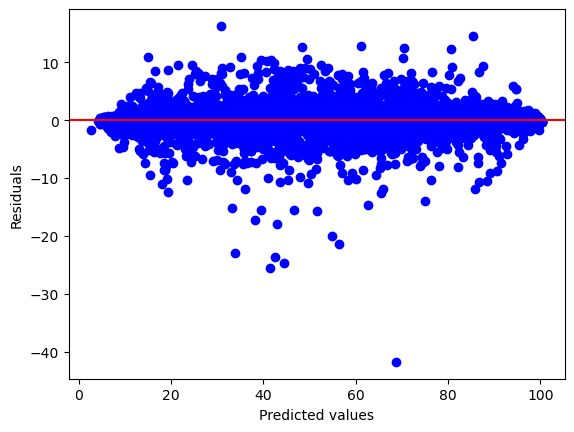

In [151]:
residuals = y_val.ravel() - y_pred_gradient.ravel()

# Plot the residuals against the predicted values
plt.scatter(y_pred_gradient, residuals, color = "blue")
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.savefig("C:/Users/leona/LUISS/Data science/Banca iccrea images/overfitting_plot.png", dpi = 300, bbox_inches = "tight")
plt.show()

## HIST GRADIENT BOOSTING

This was just a trial since we saw that this algorithm was similar to the gradient boosting but being based on histograms, it is much faster and performs very well.

In [107]:
from sklearn.ensemble import HistGradientBoostingRegressor

In [108]:
gradient_hist = HistGradientBoostingRegressor()

parameters = {
    'learning_rate': [.1, .12],
    'max_iter': [1000, 1200],
    'min_samples_leaf': [15, 20],
    'max_depth': [None, 10, 20],
    "l2_regularization" : [0.1, 0.001, 0.0001]
 }
#instantiate the gridsearch
hgb_grid = GridSearchCV(gradient_hist, parameters, n_jobs=5, 
 cv=5, scoring="r2",
 verbose=2, refit=True)
#fit on the grid 

hgb_fit = hgb_grid.fit(X_train_scaled, y_train.ravel())

y_pred_gradient_hist = hgb_fit.predict(X_val_scaled)

r2_gradient_hist = r2_score(y_val, y_pred_gradient)

rmse_gradient_hist = np.sqrt(mean_squared_error(y_val, y_pred_gradient))

Fitting 5 folds for each of 72 candidates, totalling 360 fits


In [109]:
print(r2_gradient_hist)
print(rmse_gradient_hist)
print(hgb_fit.best_params_)

0.9864334621477091
3.1960931138431317
{'l2_regularization': 0.1, 'learning_rate': 0.12, 'max_depth': 10, 'max_iter': 1200, 'min_samples_leaf': 20}


In [119]:
gradient_h = HistGradientBoostingRegressor(l2_regularization = 0.001, learning_rate = 0.12, max_depth = 20, max_iter = 1200, min_samples_leaf = 15)

hgb_fitt = gradient_h.fit(X_train_scaled, y_train.ravel())

y_pred_hist = hgb_fitt.predict(X_val_scaled)

r2_hist = r2_score(y_val, y_pred_hist)

rmse_hist = np.sqrt(mean_squared_error(y_val, y_pred_hist))


In [110]:
print(r2_gradient_hist)
print(rmse_gradient_hist)

0.9864334621477091
3.1960931138431317


## XGBOOST

In [61]:
from xgboost import XGBRegressor

In [80]:
boost = XGBRegressor()

param_boost={"learning_rate": (0.01, 0.1, 0.001),
            "max_depth": [ 3, 5, 8],
            "min_child_weight": [ 1, 3, 5, 7],
            "gamma":[ 0.0, 0.1, 0.2],
            "colsample_bytree":[ 0.3, 0.4, 0.5]
            }

grid_boost = GridSearchCV(estimator = boost, param_grid = param_boost, cv = 5, n_jobs = -1, verbose=3, scoring = "r2")

grid_result = grid_boost.fit(X_train_scaled, y_train.ravel())

y_pred_boost = grid_result.predict(X_val_scaled)

r2_boost = r2_score(y_val, y_pred_boost)

RMSE_XGB = np.sqrt(mean_squared_error(y_val, y_pred_boost))

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


In [82]:
grid_result.best_params_

{'colsample_bytree': 0.5,
 'gamma': 0.0,
 'learning_rate': 0.1,
 'max_depth': 8,
 'min_child_weight': 5}

In [62]:
boost = XGBRegressor(colsample_bytree = 0.5, gamma = 0.0, learning_rate = 0.1, max_depth = 8, min_child_weight = 5)

grid_result = boost.fit(X_train_scaled, y_train.ravel())

y_pred_boost = grid_result.predict(X_val_scaled)

r2_boost = r2_score(y_val, y_pred_boost)

RMSE_XGB = np.sqrt(mean_squared_error(y_val, y_pred_boost))

In [111]:
df_performance.loc[4] = ["XGBoost", r2_boost, RMSE_XGB]
df_performance

,Model,R2,RMSE
0,linear,0.402002,21.219487
1,SVR,0.908686,8.291892
2,Random Forest,0.984623,3.402701
3,Gradient boosting,0.986433,3.196093
4,XGBoost,0.978037,4.063961


# NEURAL NETWORK

In [112]:
import torch
import torch.nn as nn

In [113]:
# import torch.optim as optim
# import tqdm
# import copy

# Prepare the data

X_train_scaled_tc = X_train_scaled.values
X_val_scaled_tc = X_val_scaled.values

X_train_torch = torch.tensor(X_train_scaled_tc, dtype=torch.float32)
X_val_torch = torch.tensor(X_val_scaled_tc, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
y_val_torch = torch.tensor(y_val, dtype=torch.float32).reshape(-1, 1)


In [114]:
# Define the model architecture
model = nn.Sequential(
    nn.Linear(11, 24),
    nn.ReLU(),
    nn.Linear(24, 12),
    nn.ReLU(),
    nn.Linear(12, 6),
    nn.ReLU(),
    nn.Linear(6, 1)
)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [116]:
num_epochs = 10000
for epoch in range(num_epochs):
    # Forward pass
    y_pred = model(X_train_torch)
    loss = criterion(y_pred, y_train_torch)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Print the loss every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}, loss: {loss.item():.4f}")

# Evaluate the model on the test set
with torch.no_grad():
    y_pred = model(X_val_torch)
    test_loss = criterion(y_pred, y_val_torch)
    print(f"Test loss: {test_loss.item():.4f}")

y_pred = y_pred.detach().numpy()

r2tensor = r2_score(y_val, y_pred)

rmse_tensor = mean_squared_error(y_val, y_pred, squared=False)

Epoch 10, loss: 93.4158
Epoch 20, loss: 92.8622
Epoch 30, loss: 92.3227
Epoch 40, loss: 91.8004
Epoch 50, loss: 91.3010
Epoch 60, loss: 90.8414
Epoch 70, loss: 90.3939
Epoch 80, loss: 89.9526
Epoch 90, loss: 89.5357
Epoch 100, loss: 89.1055
Epoch 110, loss: 88.6908
Epoch 120, loss: 88.2824
Epoch 130, loss: 87.8739
Epoch 140, loss: 87.4686
Epoch 150, loss: 87.0689
Epoch 160, loss: 86.6718
Epoch 170, loss: 86.2790
Epoch 180, loss: 85.8899
Epoch 190, loss: 85.5061
Epoch 200, loss: 85.1248
Epoch 210, loss: 84.7469
Epoch 220, loss: 84.3728
Epoch 230, loss: 84.0015
Epoch 240, loss: 83.6333
Epoch 250, loss: 83.2720
Epoch 260, loss: 82.9123
Epoch 270, loss: 82.5594
Epoch 280, loss: 82.2137
Epoch 290, loss: 81.8690
Epoch 300, loss: 81.5298
Epoch 310, loss: 81.1924
Epoch 320, loss: 80.8591
Epoch 330, loss: 80.5304
Epoch 340, loss: 80.1923
Epoch 350, loss: 79.8702
Epoch 360, loss: 79.5579
Epoch 370, loss: 79.2563
Epoch 380, loss: 78.9618
Epoch 390, loss: 78.6788
Epoch 400, loss: 78.3973
Epoch 410

In [118]:
df_performance.loc[5] = ["Neural Network", r2tensor, rmse_tensor]
df_performance

,Model,R2,RMSE
0,linear,0.402002,21.219487
1,SVR,0.908686,8.291892
2,Random Forest,0.984623,3.402701
3,Gradient boosting,0.986433,3.196093
4,XGBoost,0.978037,4.063961
5,Neural Network,0.953177,5.937679


## HYPERPARAMETER TUNING WITH OPTUNA

Optuna is a great library to tune neural network, based on the data you have it gives you number of layers, neurons and learning rate. Unfortunately in our case (probably for our inexperience with this new library) the results given by optuna didn't improve the neural network performance, instead it worsen it.

In [ ]:
import optuna

def objective(trial):
    # Define the model architecture
    n_layers = trial.suggest_int('n_layers', 1, 3)
    layers = []
    in_features = 9
    for i in range(n_layers):
        out_features = trial.suggest_int(f'n_units_l{i}', 5, 50)
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU())
        in_features = out_features
    layers.append(nn.Linear(in_features, 1))
    model = nn.Sequential(*layers)

    # Define the hyperparameters
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)

    # Define the loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Train the model
    num_epochs = 1000
    for epoch in range(num_epochs):
        # Forward pass
        y_pred = model(X_train_torch)
        loss = criterion(y_pred, y_train_torch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate the model on the validation set
    with torch.no_grad():
        y_pred = model(X_val_torch)
        val_loss = criterion(y_pred, y_val_torch)

    return val_loss.item()

# Run the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Print the best hyperparameters and loss
print(f"Best hyperparameters: {study.best_params}")
print(f"Best loss: {study.best_value:.4f}")




class MyModel(nn.Module):
    def __init__(self, input_size, output_size, n_layers, n_units_l0, n_units_l1, n_units_l2):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.n_units_l0 = n_units_l0
        self.n_units_l1 = n_units_l1
        self.n_units_l2 = n_units_l2
        
        # Define the layers
        self.fc1 = nn.Linear(input_size, n_units_l0)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(n_units_l0, n_units_l1)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(n_units_l1, n_units_l2)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(n_units_l2, output_size)
        
        # Initialize the weights
        self._init_weights()
        
    def forward(self, x):
        # Flatten the input
        x = x.view(-1, self.input_size)
        
        # Pass the input through the layers
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        
        return x
    
    def _init_weights(self):
        # Initialize the weights using Xavier initialization
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.xavier_uniform_(self.fc4.weight)

# Create an instance of the model using the best hyperparameters
input_size = 9  # Change this to the size of your input
output_size = 1  # Change this to the size of your output
model1 = MyModel(input_size, output_size, n_layers=3, n_units_l0=49, n_units_l1=38, n_units_l2=50)

# Define the loss function and optimizer

In [119]:
from scipy.stats import f_oneway
# Perform ANOVA
f_statistic, p_value = f_oneway(y_pred.ravel(), y_pred_gradient.ravel(), y_pred_boost.ravel(), y_pred_rand.ravel())

# Print the results
print("F-statistic:", f_statistic)
print("p-value:", p_value) #0.99 no statistical difference

F-statistic: 0.029367588743930088
p-value: 0.9932255364055388


In [127]:
r2_scores_list = []
RMSE_scores_list = []

for num in range(0,5):


    X_train, X_validation, y_training, y_validation = train_test_split(X, y, test_size = 0.2, stratify = X["bins"])


    X_train = X_train.drop("bins", axis = 1)

    X_validation = X_validation.drop("bins", axis = 1)

    columns = list(X_train.iloc[:,6:].columns)

    X_train_cat = X_train[columns]

    X_val_cat = X_validation[columns]


    X_train.drop(columns, axis = 1, inplace = True)

    X_validation.drop(columns, axis = 1, inplace = True)


    col_train = X_train.columns

    from sklearn.preprocessing import StandardScaler

    sc = StandardScaler()

    X_train_scaled = pd.DataFrame(sc.fit_transform(X_train), columns = col_train)
    X_val_scaled = pd.DataFrame(sc.transform(X_validation), columns = col_train)
    y_train = y_training.values
    y_val = y_validation.values


    listmerge = []
    x = 0
    for i in X_train_scaled["Outstanding Amount"]:
        listmerge.append(x)
        x += 1


    listmerge_val = []

    xz = 0
    for el in X_val_scaled["Outstanding Amount"]:
        listmerge_val.append(xz)
        xz += 1


    X_train_scaled["merge"] = listmerge
    X_train_cat["merge"] = listmerge

    X_val_scaled["merge1"] = listmerge_val
    X_val_cat["merge1"] = listmerge_val


    X_train_scaled = pd.merge(X_train_scaled, X_train_cat, on = "merge")

    X_val_scaled = pd.merge(X_val_scaled, X_val_cat, on = "merge1")

    X_train_scaled.drop("merge", axis = 1, inplace = True)

    X_val_scaled.drop("merge1", axis = 1, inplace = True)
    
    
    


    gradient_h = HistGradientBoostingRegressor(l2_regularization = 0.001, learning_rate = 0.01, max_depth = 10, max_iter = 1200, min_samples_leaf = 15)

    hgb_fitt = gradient_h.fit(X_train_scaled, y_train.ravel())

    y_pred_hist = hgb_fitt.predict(X_val_scaled)

    r2_hist = r2_score(y_val, y_pred_hist)

    rmse_hist = np.sqrt(mean_squared_error(y_val, y_pred_hist))

    
    
    
    
    



    
    r2_scores_list.append(r2_hist)
    
    RMSE_scores_list.append(rmse_hist)
    

In [128]:
r2_scores_list

[0.9795025106087714,
 0.9809158206204519,
 0.9788797829589213,
 0.9796970291575433,
 0.9768971198029789]

In [129]:
RMSE_scores_list

[3.9125280575276573,
 3.7964853414017865,
 3.988438262491503,
 3.8983681464775763,
 4.178864861528853]

# SHAP

SHAP is a powerful library that makes use of a mathematical method to explain the predictions of machine learning models. 
It is based on the concepts of game theory and can be used to explain the predictions of any machine learning model 
by calculating the contribution of each feature to the prediction.
Here we used shap on our best model to let it be more interpretable and to understand better how this model makes its predicitons.
We want to use this library to get the insights on how our best model (gradient boosting) works.
First of all we must create an explainer putting as variables the model and the dataset which will be used to do the predictions.

In [122]:
import shap

# Initialize shap explainer object
explainer = shap.Explainer(gradient_grid.predict, X_val_scaled)

# Explain individual predictions
shap_values = explainer(X_val_scaled)

Permutation explainer: 3376it [3:52:37,  4.14s/it]                                                                     


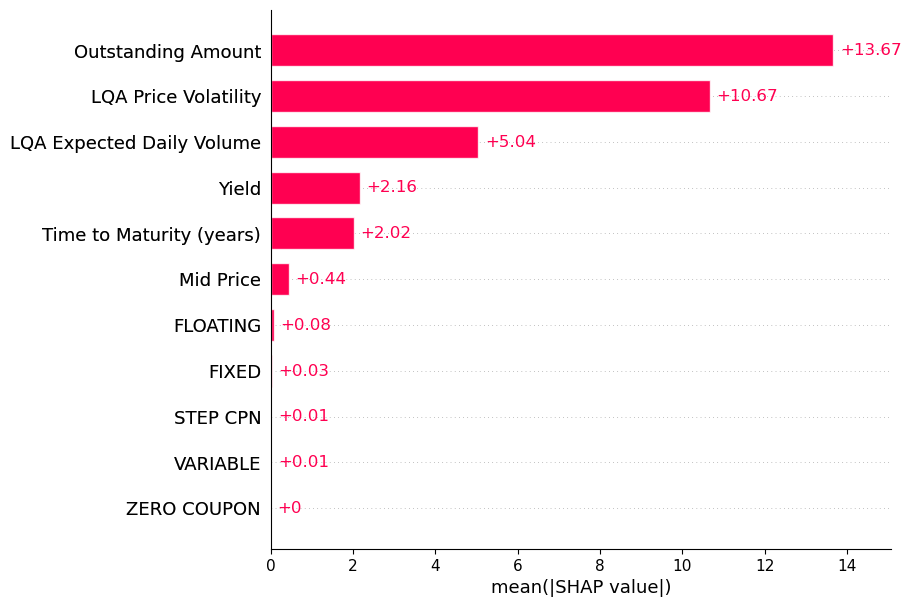

In [146]:
fig = shap.plots.bar(shap_values, max_display=12, show = False)
plt.savefig("C:/Users/leona/LUISS/Data science/Banca iccrea images/importance_plot.png", dpi = 300, bbox_inches = "tight")
plt.show()

In this graph we can see the contribution of each variable to the predictions. Higher is the shap value, higher is the importance of that predictor. Here we have only the total importance without saying if it directly or inversely correlated with the response variable

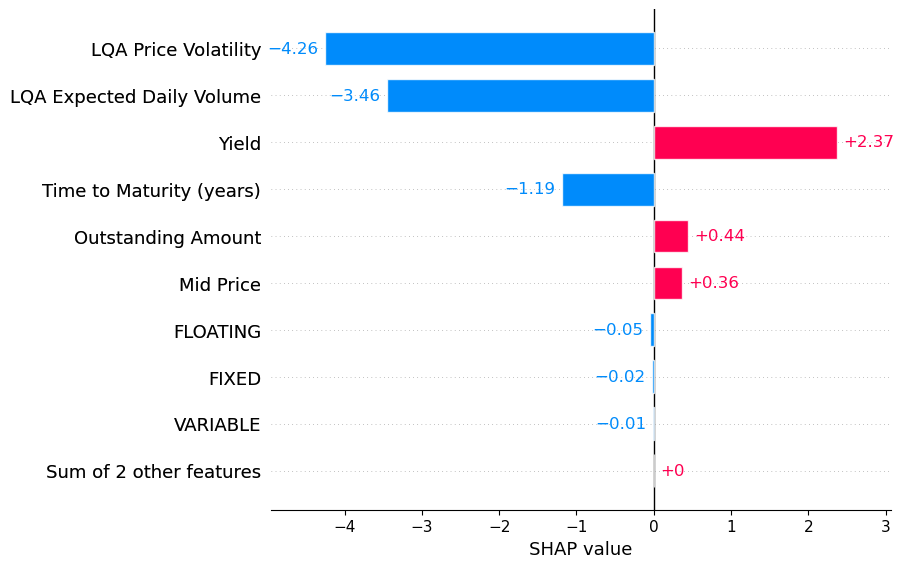

In [147]:
fig = shap.plots.bar(shap_values[0], show = False)
plt.savefig("C:/Users/leona/LUISS/Data science/Banca iccrea images/bar_plot.png", dpi = 300, bbox_inches = "tight")
plt.show()


If we use the same function but on a single observation, things become more interesting because we can see the direct or indirect relationship for each predictor with the value predicted. For example here we notice that for this single prediction the LQA EDV was the most important predictor and it is directly related to the LQA score together with Outstanding Amt. WHile the others are inversely correlated

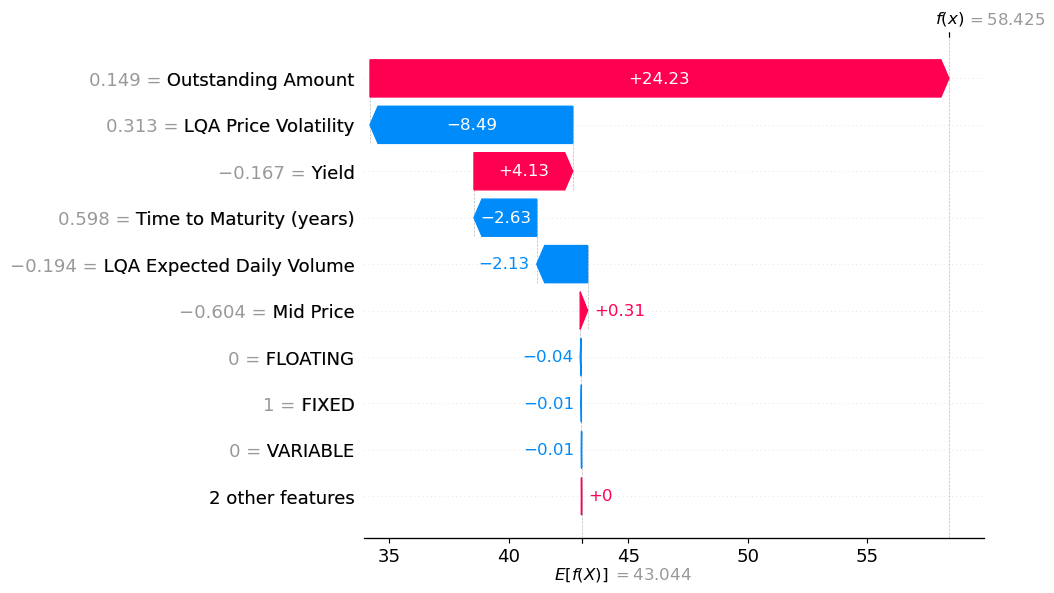

In [148]:
fig = shap.plots.waterfall(shap_values[35], show = False)
plt.savefig("C:/Users/leona/LUISS/Data science/Banca iccrea images/waterfall_plot.png", dpi = 300, bbox_inches = "tight")
plt.show()

The waterfall plot has the same information, represented in a different manner. Here we can see how the sum of all the SHAP values equals the difference between the prediction f(x) and the expected value E[f(x)] DA CAMBIARE

In [145]:
shap.initjs()
shap.plots.force(shap_values[0])

The force plot is another way to see the effect each feature has on the prediction, for a given observation. In this plot the positive SHAP values are displayed on the left side and the negative on the right side, as if competing against each other. The highlighted value is the prediction for that observation. DA CAMBIARE

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


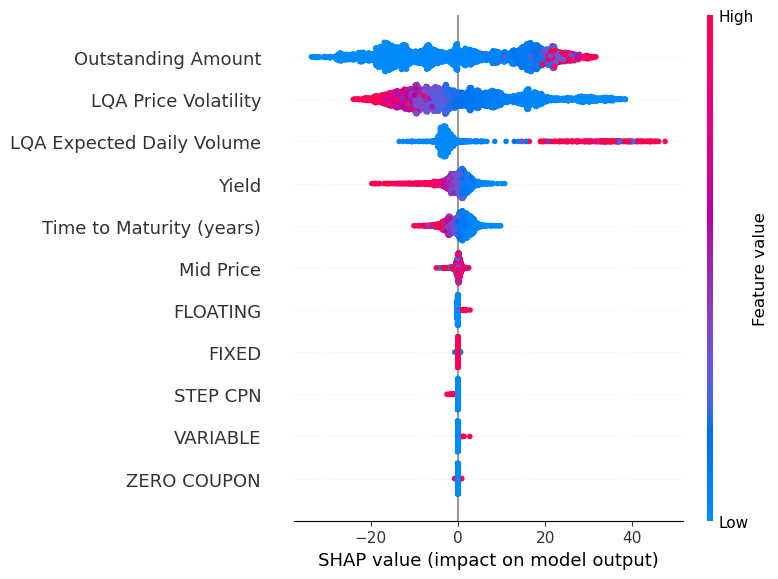

In [149]:
importance = gradient_grid.feature_importances_
shap.summary_plot(shap_values, X_val_scaled, show=False)
plt.savefig("C:/Users/leona/LUISS/Data science/Banca iccrea images/summary_plot.png", dpi = 300, bbox_inches = "tight")
plt.show()

This plot helps us a lot to see how the variables contributed, the color is the value of the feature, blue if it is low, red if it is high. The features on the left are oredered by importance and on the bottom there are the shap values. Remember that the shap values works like this: positive and high, influence directly and a lot the prediction, negative and low, influence inversely the prediction a lot.
Now, for every feature:
- Outstanding Amount: Low value of aoutstanding amount tends to influence inversely the prediction (decrease the LQA score) while high value influence positively the prediction. We can see that by the fact that blue points are mostly on the left side while on the right we find some blue points but also all the purple and red points.
- LQA Price Volatility: High price volatility tends to decrease the liquidity score (it does also make sense logically) while low  values of volatility tends to increase the liquidity score.
- LQA Expected Daily Volume: As outstanding amount, high values increase the liquidity score prediction and low values decrease it, it's interesting how the low values influence the prediction in a negative way but not so aggressively while high values have an high weight reaching shap values of 40.
- Yield: High values of yield decreases the LQA score prediction and low score increases it. The shap values are already decreasing since we are reaching less important variables.
- Time to maturity: it is very similar to Yield so if the time to maturity is low the liquidity score should have an increase in the prediction and equally high values for time to maturity will bring down the LQA score predicted value. This also have sense in a finance perspective.
- Mid Price: This feature has low predictive power but we can see at least from the extremes that Low price means decrease in the value predicted and high price means increase in the value predictive. The shap values here are low so there is not much predictive power.
- Categories of bonds: In our model the categories have very low predictive values but we firmly believe that this fact is given by a misproportion between classes, in fact stacking the three dataset we had, we saw that almost 90% of the bonds used for training are fixed bonds. We are sure that in the moment we have a more balanced dataset these categories will be absolutely of help for the model to understand how to deal with different types of bond.